# IBM Data Science Professional Certification Capstone

### The Battle of (Budapest) Neighborhoods

In this Notebook, I will conduct a study about the different ZIP code areas in the city of Budapest. I will attempt to cluster the different areas into similar clusters that share characteristics. To accomplish that, I will use the K-Means algorithm for clustering.

My motivation to do this study is two-fold: first, this will be the Capstone Project of the IBM Data Science Professional Certificate, and second, I have a personal interest, because at the time of writing, I am considering moving to another house.


Disclaimer: Some of the code in this Notebook is adaptted from the lectures of the IBM Data Science Professional Certificate.

Let's import the required Packages and Libraries.

In [119]:
import pandas as pd
import numpy as np
import random
from sklearn.cluster import KMeans

import requests # library to handle requests
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from io import StringIO

from arcgis.gis import GIS
from arcgis.geocoding import geocode

!pip -q install folium
import folium

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

Let's get the data regarding ZIP codes in Budapest. I've uploaded a .csv file in my personanl Google Drive. Original source is listed below.  
https://www.posta.hu/szolgaltatasok/iranyitoszam-kereso  

In [120]:
orig_url='https://drive.google.com/file/d/1EoL1qB5NpDGlcTV3-X2Kn-1xVExiLYEI/edit'
lisbon_url = 'https://drive.google.com/file/d/1cneWO96Jd8hMjPp-QCNMWp9s8MZMUaY7/view'

#file_id = orig_url.split('/')[-2]
file_id = lisbon_url.split('/')[-2]

download_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(download_url).text
raw_csv = StringIO(url)
postalCodes = pd.read_csv(raw_csv)

postalCodes.drop(postalCodes.columns[[0,1,2,3,-1]], inplace=True, axis=1)


In [121]:
def combinePostalCode(postalcode):
    return(f'{postalcode[0]}-{postalcode[1]}')

In [122]:
num_cod_postal = postalCodes['num_cod_postal']
ext_cod_postal = postalCodes['ext_cod_postal']

cod_postal_completo = zip(num_cod_postal, ext_cod_postal)
cod_postal_completo = list(map(lambda x: combinePostalCode(x), list(cod_postal_completo)))
postalCodes['cod_postal_completo'] = cod_postal_completo

postalCodes.drop_duplicates('cod_postal_completo', inplace=True)
postalCodes.reset_index(drop=True, inplace=True)
print(postalCodes.shape)

postalCodes_simplified = postalCodes.drop_duplicates('num_cod_postal')
postalCodes_simplified.rename(columns={'num_cod_postal':'PostalCode'}, inplace=True)
postalCodes_simplified.drop(postalCodes_simplified.columns[[-2,-1]], inplace=True, axis=1)
postalCodes_simplified.reset_index(drop=True, inplace=True)
print(postalCodes_simplified.shape)
postalCodes_simplified.head()

(9096, 13)
(43, 11)


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,cod_arteria,tipo_arteria,prep1,titulo_arteria,prep2,nome_arteria,local_arteria,troco,porta,cliente,PostalCode
0,100010611,Rua,NaN,NaN,NaN,Odette de Saint-Maurice,NaN,NaN,NaN,NaN,1700
1,1000611,Rua,NaN,NaN,NaN,Afonso Annes Penedo,NaN,Impares de 1 a 5B,NaN,NaN,1950
2,10010611,Rua,NaN,NaN,NaN,Casimiro Freire,NaN,Impares de 1 a 25A,NaN,NaN,1900
3,10030611,Rua,da,NaN,NaN,Casquilha,NaN,Impares de 1 a 39,NaN,NaN,1500
4,10090611,Rua,dos,NaN,NaN,Castelinhos,NaN,NaN,NaN,NaN,1150


Let's get the Latitudes and Longitudes for each Postal Code using the ArcGIS library.

In [123]:
gis = GIS()

#Empty Latitude and Longitude lists that will become the columns to our table with the same name
latitude_list = []
longitude_list = []

#Go through each row of the Table and add information on Latitude and Longitude for each address
for index, row in postalCodes_simplified.iterrows():
    geocode_result = geocode(address=f'{row.PostalCode} Lisboa', as_featureset=False)
    latitude_list.append(geocode_result[0]['location']['y'])
    longitude_list.append(geocode_result[0]['location']['x'])
    
postalCodes_simplified['Latitude'] = latitude_list
postalCodes_simplified['Longitude'] = longitude_list


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [124]:
postalCodes_simplified.head()

,cod_arteria,tipo_arteria,prep1,titulo_arteria,prep2,nome_arteria,local_arteria,troco,porta,cliente,PostalCode,Latitude,Longitude
0,100010611,Rua,NaN,NaN,NaN,Odette de Saint-Maurice,NaN,NaN,NaN,NaN,1700,38.756824,-9.140300
1,1000611,Rua,NaN,NaN,NaN,Afonso Annes Penedo,NaN,Impares de 1 a 5B,NaN,NaN,1950,38.744873,-9.112070
2,10010611,Rua,NaN,NaN,NaN,Casimiro Freire,NaN,Impares de 1 a 25A,NaN,NaN,1900,38.731672,-9.120495
3,10030611,Rua,da,NaN,NaN,Casquilha,NaN,Impares de 1 a 39,NaN,NaN,1500,38.740110,-9.187848
4,10090611,Rua,dos,NaN,NaN,Castelinhos,NaN,NaN,NaN,NaN,1150,38.722801,-9.141680


Now, let's draw a map to see where the Budapest ZIP code areas are.  

In [125]:
lisboa_lat = 0
lisboa_long = 0

geocode_result = geocode(address = 'Lisboa', as_featureset=False)
lisboa_lat = geocode_result[0]['location']['y']
lisboa_long = geocode_result[0]['location']['x']

lx_map = folium.Map(location=[lisboa_lat, lisboa_long], zoom_start=12)

folium.CircleMarker(
    [lisboa_lat, lisboa_long],
    radius=5,
    popup='Lisboa',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(lx_map)
    
# add popular spots to the map as blue circle markers
for lat, lng, postcode in zip(postalCodes_simplified.Latitude, postalCodes_simplified.Longitude, postalCodes_simplified.PostalCode):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=f'{postcode}',
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.6
        ).add_to(lx_map)

# display map
lx_map

Next, let's get extra details for each district from Foursquare.

In [126]:
#Foursquare API credentials. Removed for sharing in GitHub
CLIENT_ID = ''
CLIENT_SECRET = ''
VERSION = '20180605' # Foursquare API version
LIMIT = 100
RADIUS = 500

In [127]:
def getNearbyVenues(names, latitudes, longitudes, radius=RADIUS):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'PostalCode Latitude', 
                  'PostalCode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [128]:
df_bp_venues = getNearbyVenues(names=postalCodes_simplified['PostalCode'], latitudes=postalCodes_simplified['Latitude'], longitudes=postalCodes_simplified['Longitude'])
df_bp_venues.head()

,PostalCode,PostalCode Latitude,PostalCode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1700,38.756824,-9.1403,Salsa & Coentros,38.757002,-9.139162,Portuguese Restaurant
1,1700,38.756824,-9.1403,RCA Club,38.756888,-9.142162,Music Venue
2,1700,38.756824,-9.1403,Everest Montanha,38.757576,-9.142347,Indian Restaurant
3,1700,38.756824,-9.1403,Restaurante Courenses,38.755032,-9.141452,Portuguese Restaurant
4,1700,38.756824,-9.1403,Adega da Bairrada,38.757895,-9.137717,Portuguese Restaurant


In the next step, let's process the places of relevance in Budapest to have only normalized scalar data.

In [129]:
# one hot encoding
df_bp_onehot = pd.get_dummies(df_bp_venues[['Venue Category']], prefix="", prefix_sep="")

# add the 'District' column to the dataframe
df_bp_onehot['PostalCode'] = df_bp_venues['PostalCode'] 

# move neighborhood column to the first column
fixed_columns = [df_bp_onehot.columns[-1]] + list(df_bp_onehot.columns[:-1])
df_bp_onehot = df_bp_onehot[fixed_columns]

#Get the frequency for each Value Category
df_bp_grouped = df_bp_onehot.groupby('PostalCode').mean().reset_index()

In [130]:
df_bp_grouped.head()

,PostalCode,Accessories Store,African Restaurant,American Restaurant,Amphitheater,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Trail,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfront,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,1000,0.0,0.000000,0.0,0.000000,0.020408,0.020408,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.020408,0.0
1,1049,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.027778,0.0,0.0,0.0,0.0,0.000000,0.0
2,1050,0.0,0.000000,0.0,0.016129,0.000000,0.000000,0.032258,0.0,0.016129,...,0.0,0.0,0.0,0.064516,0.0,0.0,0.0,0.0,0.000000,0.0
3,1067,0.0,0.000000,0.0,0.018868,0.000000,0.000000,0.037736,0.0,0.018868,...,0.0,0.0,0.0,0.037736,0.0,0.0,0.0,0.0,0.000000,0.0
4,1068,0.0,0.017241,0.0,0.000000,0.000000,0.017241,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0


Now, let's create a table with the Top10 places in each Postal Code.

In [131]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In the following lines, let's explore different configurations for the K-Means algorithm and plot the Distortion as a funciton of number of clusters (k).

In [132]:
df_bp_grouped_clustering = df_bp_grouped.drop('PostalCode', 1)
df_bp_grouped_clustering.head()

distortions = []
for k in range(1,20):
    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_bp_grouped_clustering)
    distortions.append(kmeans.inertia_)


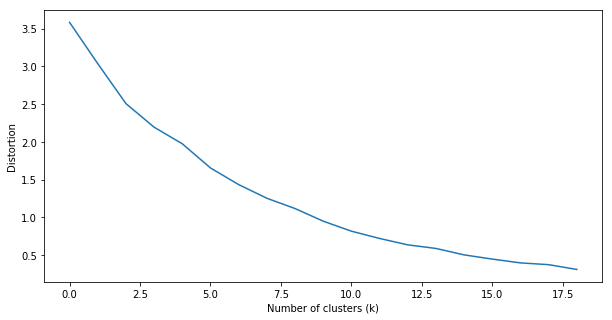

In [133]:
plt.figure(figsize=(10,5))
plt.plot(distortions)
plt.ylabel('Distortion')
plt.xlabel('Number of clusters (k)')
plt.show()

According to the chart, there seems to be an 'elbow' in the region around 8 clusters. However, when plotting in the map, the resulting clustering, there's a bunch of dots with the same colour in Budapest city center. This doesn't give too much information about that areas, so let's increase the number of clusters, to have more information about that area. After different tries, it seems a number of 50 clusters provide a good separation of ZIP code areas in the city center.

In [134]:
# set number of clusters
kclusters = 7

df_bp_grouped_clustering = df_bp_grouped.drop('PostalCode', 1)
df_bp_grouped_clustering.head()
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_bp_grouped_clustering)


Now, let's figure out which are the top venues for each ZIP code area.

In [135]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
pcs_venues_sorted = pd.DataFrame(columns=columns)
pcs_venues_sorted['PostalCode'] = df_bp_grouped['PostalCode']

for ind in np.arange(df_bp_grouped.shape[0]):
    pcs_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_bp_grouped.iloc[ind, :], num_top_venues)

pcs_venues_sorted.head()

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1000,Bakery,Portuguese Restaurant,Coffee Shop,Hotel,Plaza,BBQ Joint,Restaurant,Grocery Store,Bar,Burger Joint
1,1049,Portuguese Restaurant,Indian Restaurant,Café,Gym / Fitness Center,Restaurant,Seafood Restaurant,Deli / Bodega,Burger Joint,Garden,Greek Restaurant
2,1050,Vegetarian / Vegan Restaurant,Coffee Shop,Portuguese Restaurant,Italian Restaurant,Japanese Restaurant,Pizza Place,Hotel,Indian Restaurant,Art Museum,Grocery Store
3,1067,Coffee Shop,Portuguese Restaurant,Hotel,Burger Joint,Art Museum,Spanish Restaurant,Frozen Yogurt Shop,Pizza Place,Gourmet Shop,Japanese Restaurant
4,1068,Hotel,Gym,Café,Portuguese Restaurant,Snack Place,Hotel Bar,Burger Joint,Mediterranean Restaurant,Brazilian Restaurant,Bistro


In [136]:
# add clustering labels
pcs_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#pcs_venues_sorted.info()

#df_bp_merged = BP_postalCodes
df_bp_merged = pcs_venues_sorted

# merge Budapest Clustered and Ranked data with Budapest data to add latitude/longitude for each neighborhood
#df_bp_merged = df_bp_merged.join(pcs_venues_sorted.set_index('PostalCode'), on='PostalCode')
df_bp_merged = df_bp_merged.join(postalCodes_simplified.set_index('PostalCode'), on='PostalCode')

df_bp_merged.head()

,Cluster Labels,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,...,prep1,titulo_arteria,prep2,nome_arteria,local_arteria,troco,porta,cliente,Latitude,Longitude
0,2,1000,Bakery,Portuguese Restaurant,Coffee Shop,Hotel,Plaza,BBQ Joint,Restaurant,Grocery Store,...,NaN,NaN,NaN,Cervantes,NaN,Impares de 1A a 9C,NaN,NaN,38.741667,-9.138875
1,3,1049,Portuguese Restaurant,Indian Restaurant,Café,Gym / Fitness Center,Restaurant,Seafood Restaurant,Deli / Bodega,Burger Joint,...,dos,NaN,NaN,Defensores de Chaves,NaN,NaN,21,DÄÅ NCIO MEDIAÄâ¡ÄÂO DE SEGUROS LDA,38.736690,-9.139331
2,2,1050,Vegetarian / Vegan Restaurant,Coffee Shop,Portuguese Restaurant,Italian Restaurant,Japanese Restaurant,Pizza Place,Hotel,Indian Restaurant,...,NaN,NaN,NaN,5 de Outubro,NaN,Impares de 113 a 137C,NaN,NaN,38.736836,-9.151630
3,2,1067,Coffee Shop,Portuguese Restaurant,Hotel,Burger Joint,Art Museum,Spanish Restaurant,Frozen Yogurt Shop,Pizza Place,...,de,NaN,NaN,Berna,NaN,NaN,45,FUNDAÄâ¡ÄÂO CALOUSTE GULBENKIAN,38.737015,-9.154360
4,0,1068,Hotel,Gym,Café,Portuguese Restaurant,Snack Place,Hotel Bar,Burger Joint,Mediterranean Restaurant,...,NaN,NaN,NaN,Praia da VitÄÅria,NaN,NaN,48,CTT CORREIOS,38.726390,-9.149480


And let's plot the results of the K-Means algorithm in a map of the city, with color coding to differentiate between clusters.

In [137]:
# create map
bp_map_clusters = folium.Map(location=[budapest_lat, budapest_long], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
random.shuffle(rainbow) # sometimes clusters geographically close to each other get assigned very similar colors, so it's necessary to shuffle the color palette

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_bp_merged['Latitude'], df_bp_merged['Longitude'], df_bp_merged['PostalCode'], df_bp_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(bp_map_clusters)
       
bp_map_clusters

Let's check which are the clusters that agregate more postal codes, i.e. what are the most common types of postal codes.

In [138]:
top_cluster_num = 10
df_bp_merged['Cluster Labels'].value_counts().head(top_cluster_num)

2    17
3    13
0     8
5     2
6     1
4     1
1     1
Name: Cluster Labels, dtype: int64

Seems about half of Postal Codes are of cluster type 0, 6, and 48. Let's understand better what each type of cluster is.  
NOTE: if you re-run this code at a later date, you will probably get different clustering and numbers. That's becasue point of interest data from Foursquare is constantly evolving, and so will the caracteristics of each ZIP/Postal code area.

In [139]:
df_cluster_eval = pd.DataFrame(kmeans.cluster_centers_)
df_cluster_eval.columns = df_bp_grouped.columns[1:]

eval_list= df_bp_merged['Cluster Labels'].value_counts().head(top_cluster_num)

for cluster_type,pc_count in eval_list.iteritems():
    print(f'Top places for cluster {cluster_type}:')
    print(f'(Contains {pc_count} Postal Codes)\n')
    print(df_cluster_eval.T[cluster_type].nlargest(10))
    print('\n\n')

Top places for cluster 2:
(Contains 17 Postal Codes)

Restaurant                       0.062682
Portuguese Restaurant            0.061863
Café                             0.051200
Hotel                            0.046181
Coffee Shop                      0.033940
Bakery                           0.031736
Italian Restaurant               0.030926
Supermarket                      0.028965
Burger Joint                     0.028813
Vegetarian / Vegan Restaurant    0.023431
Name: 2, dtype: float64



Top places for cluster 3:
(Contains 13 Postal Codes)

Portuguese Restaurant    0.200204
Café                     0.071435
Restaurant               0.032840
Hotel                    0.028554
Plaza                    0.022852
Hostel                   0.022460
Japanese Restaurant      0.022436
Coffee Shop              0.022150
Indian Restaurant        0.021672
Bakery                   0.020206
Name: 3, dtype: float64



Top places for cluster 0:
(Contains 8 Postal Codes)

Hotel                    

The numbers above show the top 10 types of points of interest that are more popular in the aforementioned clusters. For instance, there seems to be a lot of Bus Stops in ZIP code areas associated with cluster 6 (Royal Blue color in the 50 cluster map), so if access to public transportation is important to you, you might want to consider living in such a ZIP code area.  

On the other hand, ZIP code areas in cluster 9 (Dodger Blue color in the 50 cluster map) seem to be a good balance between Bars, Gyms, Hotels, Train Stations, and Tram Stations.


Finaly, let's draw only the top Clusters

In [140]:
# create map
bp_map_top_clusters = folium.Map(location=[budapest_lat, budapest_long], zoom_start=13)

# set color scheme for the clusters

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

top_cluster_list = df_bp_merged['Cluster Labels'].value_counts().head(top_cluster_num).index
df_bp_merged_top_clust = df_bp_merged[df_bp_merged['Cluster Labels'].isin(top_cluster_list)]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_bp_merged_top_clust['Latitude'],
                                  df_bp_merged_top_clust['Longitude'],
                                  df_bp_merged_top_clust['PostalCode'],
                                  df_bp_merged_top_clust['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(bp_map_top_clusters)
       
bp_map_top_clusters

Thank you for reading until the end!  
José Fernandes